## Setup, load model

In [2]:
file_name = '../Chandra_data/large_eventfiles_lifetime28800_randomshift.pkl'
model_name = '../experiments/testthin_finetune2_large_TVseparate_E3_decoder_lamTV10_lamlatent1_8latents_512hidden_5blocks_B16'
checkpoint = 'model_300epochs_lr1e-05.ckpt'

latent_num = 109656

title_size = 26
label_size = 22
tick_size = 20


from utils import *
from dataset import *
from autodecoder import *
import pickle
import json
class DotDict:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            if isinstance(value, dict):
                value = DotDict(value)
            self.__dict__[key] = value
device = "cuda"
B = 32
num_freqs = 12

# Load model
encoding = PositionalEncoding(num_freqs=num_freqs,include_input=True)
with open(f'{model_name}/arguments.json', 'r') as file:
    opt = json.load(file)
opt = DotDict(opt)
model = AutoDecoder.load_from_checkpoint(f'{model_name}/{checkpoint}', opt=opt, encoding=encoding, latent_num=latent_num)
model.to(device);


## For new data, one or more sources
Data format: should be a list of dic
    - Each dict contains the key 'event_list' among others
        - event_list is a N * 2 np.array where the first column is time, second column is energy

In [2]:
# # Optional: visualize some new source
# temp = np.load("/nobackup/users/yankeson/Astronomy/Chandra_data/new_sources/acisf22096_000N020_r0009_regevt3_filter.npz")
# d = {file: temp[file] for file in temp.files}
# event_list = d['event_list']
# event_list[:,0] = event_list[:,0] - min(event_list[:,0])
# event_list = onehot_code_energy(event_list, E_grid = np.asarray([5,12,20,70]) * 100)

# t_scale = 28800
# nbins = 96

# figsize=(12,3)
# fig, axes = plt.subplots(1, 4, figsize=figsize)


# axes[0].hist(event_list[:,0], bins=100);
# for j in range(3):
#     inds = np.where(event_list[:,j+1] == 1)[0]
#     axes[j+1].hist(event_list[inds,0], bins=100);

In [9]:
# Periodic flares
# prefix = "/nobackup/users/yankeson/Astronomy/Chandra_data/new_sources/acisf22096_000N020_r0009_regevt3_filter"
# temp = np.load(f"{prefix}.npz")
# d = {file: temp[file] for file in temp.files}
# new_source_list = [d]
# new_source_list = prune(new_source_list)

prefix = "/nobackup/users/yankeson/Astronomy/Chandra_data/new_sources/events_for_inference"
temp = f"{prefix}.pkl"
import pickle
with open(temp, 'rb') as f:
    new_source_list = pickle.load(f)
pruned_list = prune(new_source_list)

# data = RealEventsDataset(pruned_list, t_scale=28800)
# test_loader = DataLoader(data, batch_size=B, collate_fn=padding_collate_fn)


# test_list = pruned_list[:1]
test_data = RealEventsDataset(test_list, t_scale=28800)
test_loader = DataLoader(test_data, batch_size=B, collate_fn=padding_collate_fn)
test_batch = next(iter(test_loader))
test_batch = todevice(test_batch, device)

In [6]:
# from dataset import compute_statistics
# import time


# start_time = time.time()
# m_max = 50

# def cccompute_statistics(data_lst, t_scale):
#     '''
#     Compute different statistics for a list of data.
#     Input:
#         - data_lst: a list containing dictionaries. Each dic should have a "event_list" key.
#             - event_list: (N, 2)
#     Output: data_lst, with additional summary statistics computed
#     '''
#     for d in data_lst:
#         event_list = d['event_list']
        
#         # Normalize
#         d['event_list'][:,0] = d['event_list'][:,0] - np.min(d['event_list'][:,0])
#         event_list = d['event_list']
        
#         # Three different lists
#         soft_list = event_list[(event_list[:,1]>500) & (event_list[:,1]<=1200),0]
#         medium_list = event_list[(event_list[:,1]>1200) & (event_list[:,1]<=2000),0]
#         high_list = event_list[(event_list[:,1]>2000) & (event_list[:,1]<=7000),0]
#         event_list = event_list[:,0]
        
#         # Hardness ratio
#         soft_flux = np.array(len(soft_list))
#         med_flux = np.array(len(medium_list))
#         high_flux = np.array(len(high_list))
#         d['hard_hm'] = (high_flux - med_flux) / (high_flux + med_flux)
#         d['hard_ms'] = (med_flux - soft_flux) / (med_flux + soft_flux)
#         d['hard_hs'] = (high_flux - soft_flux) / (high_flux + soft_flux)

#         # Variability Index!
#         P, var_index = glvary(event_list, t_scale, m_max=m_max)
#         d['var_prob_b'] = P
#         d['var_index_b'] = var_index
#         d['var_prob_s'] = glvary(soft_list, t_scale, m_max=m_max)[0]
#         d['var_prob_m'] = glvary(medium_list, t_scale, m_max=m_max)[0]
#         d['var_prob_h'] = glvary(high_list, t_scale, m_max=m_max)[0]
        
#     return data_lst


# test_list = cccompute_statistics(test_list, 28800)


# end_time = time.time()

# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

In [10]:

# import time


# start_time = time.time()


# test_batch = model.optimize_new_latent(test_batch, optimization_epochs=500, lr=0.01, init='center', neg_likelihood_only=False, verbose=True)


# end_time = time.time()

# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

### Convert new sources into dataset and do test time optimization

In [11]:
target_prefix = prefix

outputs = []
for idx, batch in enumerate(test_loader):
    temp = idx * B
    if temp % 128 == 0:
        print(f'processed {temp} sources')
    batch = todevice(batch, device)
    batch = model.optimize_new_latent(batch, optimization_epochs=500, lr=0.01, init='center', neg_likelihood_only=False, verbose=True)
    outputs.append(todevice(batch,'cpu'))
    
def output_collate_fn(outputs):
    '''
    Outputs is a list of dic
    '''
    output = {}
    for key in outputs[0].keys():
        if key in ['latent','T','num_events','class','hard_hm','hard_hs','hard_ms','var_prob_b','var_prob_s','var_prob_m','var_prob_h','var_index_b']:
            output[key] = torch.cat([o[key] for o in outputs], dim=0)
        # elif key == 'class':
        #     output[key] = sum([o[key] for o in outputs],[])
        else:
            output[key] = [o[key] for o in outputs]
    return output

collated_outputs = output_collate_fn(outputs)


# np.save(f"{target_prefix}_latents.npy", collated_outputs['latent'].detach().cpu().numpy())

processed 0 sources
after 0 epochs, loss are -4795.86
after 10 epochs, loss are -7358.64
after 20 epochs, loss are -8398.63
after 30 epochs, loss are -9580.87
after 40 epochs, loss are -10395.65
after 50 epochs, loss are -10819.56
after 60 epochs, loss are -11034.56
after 70 epochs, loss are -11260.14
after 80 epochs, loss are -11402.75
after 90 epochs, loss are -11497.12
after 100 epochs, loss are -11580.42
after 110 epochs, loss are -11649.47
after 120 epochs, loss are -11744.96
after 130 epochs, loss are -11925.40
after 140 epochs, loss are -12153.41
after 150 epochs, loss are -12609.84
after 160 epochs, loss are -13108.57
after 170 epochs, loss are -13586.63
after 180 epochs, loss are -14056.56
after 190 epochs, loss are -14539.01
after 200 epochs, loss are -15008.03
after 210 epochs, loss are -15447.64
after 220 epochs, loss are -15891.29
after 230 epochs, loss are -16333.84
after 240 epochs, loss are -16769.84
after 250 epochs, loss are -17210.82
after 260 epochs, loss are -17631

In [16]:
collated_original_idx = torch.cat(collated_outputs['original_idx'],dim=0)
output_d = {'latents': collated_outputs['latent'].detach().cpu().numpy(),
            'original_idx': collated_original_idx.detach().cpu().numpy()}
output_d.keys()
with open(f"{target_prefix}_latents.pkl", 'wb') as f:
    pickle.dump(output_d, f)


## For already have data

In [11]:
file_name = f'{model_name}/latent_latest.pkl'
with open(file_name, 'rb') as file: 
    collated_outputs = pickle.load(file)
data = {}
for key in ['latent', 'hard_hm', 'hard_ms', 'hard_hs', 'var_prob_b', 'var_index_b', 'var_prob_s', 'var_prob_m', 'var_prob_h']:
    data[key] = collated_outputs[key].numpy()

In [12]:
# Optional: search for it
target = '13814_567'
N = 109656
inds = []
for i in range(N):
    b = i // B
    bb = i % B
    if target in collated_outputs['id'][b][bb]:
        print(i, collated_outputs['id'][b][bb])
        inds.append(i)
print(inds)
print(len(inds))

90436 13814_567_5
90437 13814_567_4
90438 13814_567_6
90439 13814_567_3
90440 13814_567_2
90446 13814_567_1
[90436, 90437, 90438, 90439, 90440, 90446]
6


## Some visualization

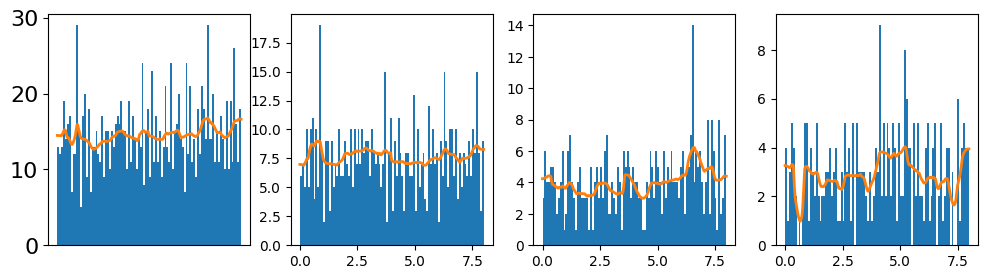

In [31]:
####### Reconstruction
# for new source
# batch_index = 0
# index = 0

# for old source
total_index = 1793
batch_index = total_index // B
index = total_index % B

t_scale = 28800
nbins = 96

figsize=(12,3)
fig, axes = plt.subplots(1, 4, figsize=figsize)

mask = collated_outputs['mask'][batch_index][index]
unfiltered_times = collated_outputs['event_list'][batch_index][index,mask,:] * t_scale / 3600
total_mask = collated_outputs['total_mask'][batch_index][index]
total_times = collated_outputs['total_list'][batch_index][index,total_mask,0] * t_scale / 3600
rates = collated_outputs['total_rates'][batch_index][index,total_mask] / nbins
axes[0].hist(unfiltered_times[:,0], bins = nbins,label='Actual counts')
axes[0].plot(total_times, torch.sum(rates,dim=-1),label='Fitted rate',linewidth=2)
axes[0].tick_params(axis='both', which='major', labelsize=tick_size)
axes[0].set_xticks([])

for j in range(3):
    E_mask = (unfiltered_times[:,j+1]>0)
    times = unfiltered_times[E_mask,0]
    axes[j+1].hist(times, bins = nbins, label='Actual counts')
    axes[j+1].plot(total_times, rates[:,j], label='Fitted rate',linewidth=2)

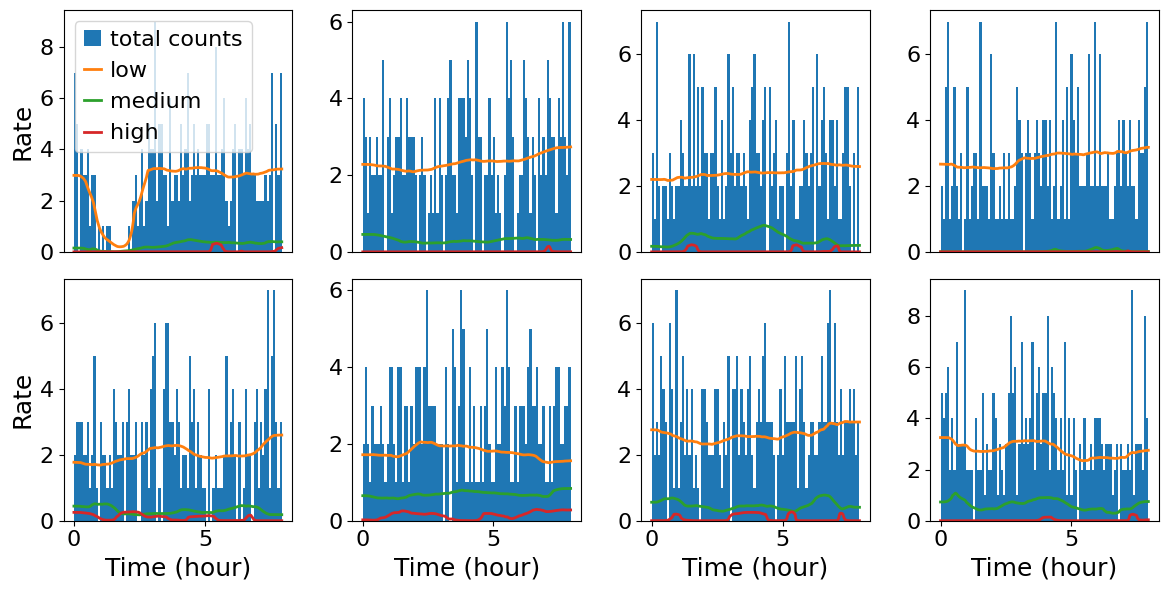

In [33]:
####### Anomaly detection
# seed_index = 64709
# target_prefix = '/nobackup/users/yankeson/Astronomy/Chandra_data/new_sources/2CXO_J005440_5_374320'
seed_index = 90438
target_prefix = '/nobackup/users/yankeson/Astronomy/Chandra_data/new_sources/2CXO_J132943_3_471134'


save_name1 = f'{target_prefix}_anomaly_class.pdf'
save_name2 = f'{target_prefix}_anomaly_class.png'

# Load data
file_name = f'{model_name}/latent_latest.pkl'
with open(file_name, 'rb') as file: 
    collated_outputs = pickle.load(file)
data = {}
for key in ['latent', 'hard_hm', 'hard_ms', 'hard_hs', 'var_prob_b', 'var_index_b', 'var_prob_s', 'var_prob_m', 'var_prob_h']:
    data[key] = collated_outputs[key].numpy()
    
    
    
# New latent
# seed_latent = np.load(f"{target_prefix}_latents.npy")

# Old latent
seed_latent = X[seed_index,:]

title_size=26
label_size=18
legend_size=16
tick_size=16
figsize=(12,6)
nbins=96
t_scale=28800
B=64


nrow = 2
ncol = 4

X = data['latent']
k = nrow * ncol

# Compute L2 distances
distances = np.linalg.norm(X - seed_latent, axis=1)
closest_rows_indices = np.argpartition(distances, k)[:k]
indices = closest_rows_indices[np.argsort(distances[closest_rows_indices])]

labels = ['low','medium','high']

fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
for i, total_index in enumerate(indices):
    irow = i // ncol
    icol = i % ncol

    batch_index = total_index // B
    index = total_index % B

    mask = collated_outputs['mask'][batch_index][index]
    unfiltered_times = collated_outputs['event_list'][batch_index][index,mask,:] * t_scale / 3600
    total_mask = collated_outputs['total_mask'][batch_index][index]
    total_times = collated_outputs['total_list'][batch_index][index,total_mask,0] * t_scale / 3600
    rates = collated_outputs['total_rates'][batch_index][index,total_mask] / nbins

    T = collated_outputs['T'][total_index] * t_scale

    axes[irow,icol].hist(unfiltered_times[:,0], bins = nbins,label='total counts')
    # Rate for each bin
    for j in range(3):
        E_mask = (unfiltered_times[:,j+1]>0)
        times = unfiltered_times[E_mask,0]
        axes[irow,icol].plot(total_times, rates[:,j], label=labels[j],linewidth=2)
        axes[irow,icol].tick_params(axis='both', which='major', labelsize=tick_size)
        
        
        
    if irow != nrow-1:
        axes[irow,icol].set_xticks([])
    else:
        axes[irow,icol].set_xlabel('Time (hour)', fontsize=label_size)
    if irow==0 and icol==0:
        axes[irow,icol].legend(loc='upper left', fontsize=legend_size, handlelength=0.8, handletextpad=0.4)
    if icol == 0:
        axes[irow,icol].set_ylabel('Rate', fontsize=label_size)

plt.tight_layout()
plt.savefig(save_name1)
plt.savefig(save_name2)

# Scratch space